In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
import pathlib

COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]
MAX_TRAIN_FORECASTS = 14

Using TensorFlow backend.


In [2]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES

In [42]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")

In [124]:
((answers.Xmax - answers.Xmin) / (answers.Ymax - answers.Ymin)).sort_values().iloc[:-2]

itemId
30274    0.398773
34339    0.461347
15096    0.500000
18096    0.511820
30097    0.522604
9333     0.526549
3019     0.544304
11891    0.544872
5389     0.552632
31182    0.563011
29669    0.591743
6736     0.598425
23916    0.600382
5519     0.611898
21356    0.628049
23728    0.630952
28021    0.644444
20275    0.649266
28917    0.649299
10916    0.650485
32303    0.652941
32337    0.653061
14574    0.657563
35962    0.658451
25142    0.666667
33304    0.666667
4788     0.669206
1518     0.669675
15421    0.670085
5670     0.673254
           ...   
17925    2.137441
34994    2.152344
18281    2.165468
8438     2.226277
29182    2.240000
13504    2.247148
441      2.300725
13145    2.353535
9292     2.364865
33897    2.380165
12215    2.421053
27121    2.462733
23609    2.474747
16238    2.482540
16237    2.488506
7673     2.496000
30112    2.559271
5205     2.565217
29645    2.583333
15026    2.602459
21424    2.625000
9027     2.655052
13260    2.666667
23173    2.706186
157

In [111]:
def aug_batch(x, y, err=0.1):
    err = np.exp(np.random.random(2) * err * 2 - err)
    err = np.hstack([err, err])
    return x * np.reshape(err, (1, 1, 4)), y * np.reshape(err, (1, 4))

In [76]:
def yield_batch(batch_size):
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield aug_batch(x, y)

In [62]:
def yield_batch_val():
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [60]:
def yield_batch_test():
    item_ids = votes_test.index.unique()
    for item_id in item_ids:
        forecasts = votes_test.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [5]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [112]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    y_rez = layers.GlobalAveragePooling1D()(y)
    
    # 2 слоя с множетелем 4
    mul = 4
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=True
    ))(y)
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=False
    ))(y)
    
    y = layers.Dense(
        units=filters * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters // 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    y = layers.add([y_rez, y])
    y = layers.Activation("relu")(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [72]:
def train_model(batch_size, units, epochs=100):
    model = make_model(units)
    
    lr=0.0001
    
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, min_delta=0.0001, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(),
        validation_steps=len(set(votes.index))
    )
    return rez, model

In [113]:
rez, model = train_model(1, 32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    136192      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          394240      bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

1000/1000 [==============================] - 17s 17ms/step - loss: -0.5654 - val_loss: -0.5704

Epoch 00026: val_loss did not improve from -0.57147

Epoch 00026: ReduceLROnPlateau reducing learning rate to 8.589933713665232e-06.
Epoch 27/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.5784 - val_loss: -0.5719

Epoch 00027: val_loss improved from -0.57147 to -0.57191, saving model to ../processed/model.h5
Epoch 28/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.5663 - val_loss: -0.5722

Epoch 00028: val_loss improved from -0.57191 to -0.57220, saving model to ../processed/model.h5
Epoch 29/100
1000/1000 [==============================] - 17s 17ms/step - loss: -0.5690 - val_loss: -0.5719

Epoch 00029: val_loss did not improve from -0.57220

Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.871946970932186e-06.
Epoch 30/100
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5599 - val_loss: -0.5726

Epoch 0003

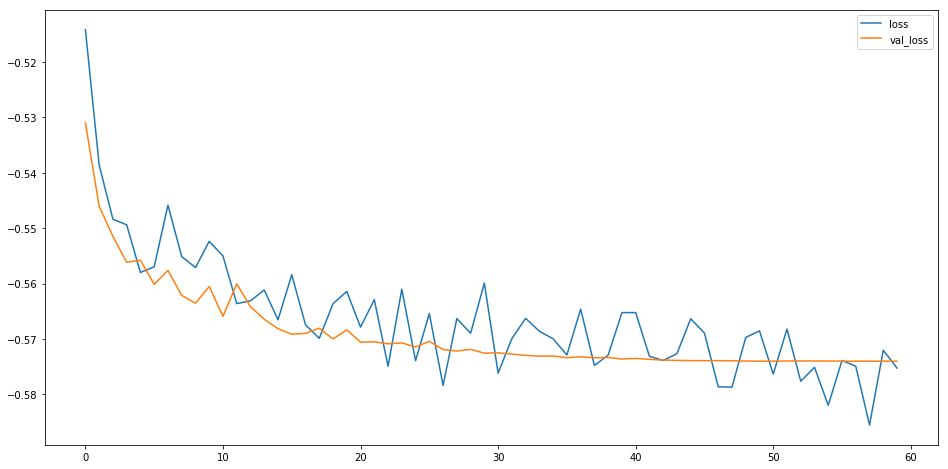

In [114]:
pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))

In [115]:
def make_forecast(model):
    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    feat = yield_batch_test()
    df = model.predict_generator(feat, steps=len(votes_test.index.unique()))
    df = pd.DataFrame(df, index=votes_test.index.unique())
    df.to_csv(path / "_sub_full.csv", header=False)
    # path.rename(path.parent / f"{subdir}-{score:0.1f}")

In [116]:
make_forecast(model)